In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Load the datasets
train_transaction = pd.read_csv('train_transaction_sample.csv')
test_transaction = pd.read_csv('test_transaction_sample.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

In [3]:
# Merge the datasets on TransactionID
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [4]:
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
# Display the first few rows of the merged datasets
print(train_data.head())
print(test_data.head())

print("Size of train data:", train_data.shape)
print("Size of test data:", test_data.shape)

# Check for missing values
print("Missing values in train data:", train_data.isnull().sum().sum())
print("Missing values in test data:", test_data.isnull().sum().sum())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5              ...                \
0    NaN    150    discover    142              ...                 
1  404.0    150  mastercard    102              ...                 
2  490.0    150        visa    166              ...                 
3  567.0    150  mastercard    117              ...                 
4  514.0    150  mastercard    102              ...                 

                 id_31  id_32      id_33           id_34  id_35 id_36 id_37  \
0                  NaN    NaN        NaN   

In [6]:
# Fill missing values
train_data.fillna(-999, inplace=True)
test_data.fillna(-999, inplace=True)

# Define features and target
X = train_data.drop(columns=['isFraud', 'TransactionID'])
y = train_data['isFraud']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)
test_data = pd.get_dummies(test_data.drop(columns=['TransactionID']))

# Ensure the train and test datasets have the same dummy variables
X, test_data = X.align(test_data, join='left', axis=1, fill_value=0)

# Check the balance of target classes
print("Class distribution in target variable:")
print(y.value_counts())

Class distribution in target variable:
0    35
Name: isFraud, dtype: int64


In [11]:
# Split the data into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes of the splits
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Class distribution in training set:\n", y_train.value_counts())
print("Class distribution in validation set:\n", y_val.value_counts())

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_data_scaled = scaler.transform(test_data)

Training set size: (28, 499)
Validation set size: (7, 499)
Class distribution in training set:
 0    28
Name: isFraud, dtype: int64
Class distribution in validation set:
 0    7
Name: isFraud, dtype: int64


In [12]:
# Build the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [13]:
# Evaluate the model
y_pred = model.predict(X_val_scaled)
y_pred_proba = model.predict_proba(X_val_scaled)

# Check the shape of y_pred_proba
print("Shape of y_pred_proba:", y_pred_proba.shape)

# Ensure we have probabilities for both classes
if y_pred_proba.shape[1] > 1:
    y_pred_proba = y_pred_proba[:, 1]
else:
    y_pred_proba = y_pred_proba[:, 0]
    print("Only one class present in y_pred_proba. ROC AUC score might not be defined.")

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Calculate ROC AUC score if applicable
if len(np.unique(y_val)) > 1:
    roc_auc = roc_auc_score(y_val, y_pred_proba)
else:
    roc_auc = 'undefined'

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nROC AUC Score:", roc_auc)


Shape of y_pred_proba: (7, 1)
Only one class present in y_pred_proba. ROC AUC score might not be defined.
Confusion Matrix:
[[7]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7

avg / total       1.00      1.00      1.00         7


ROC AUC Score: undefined


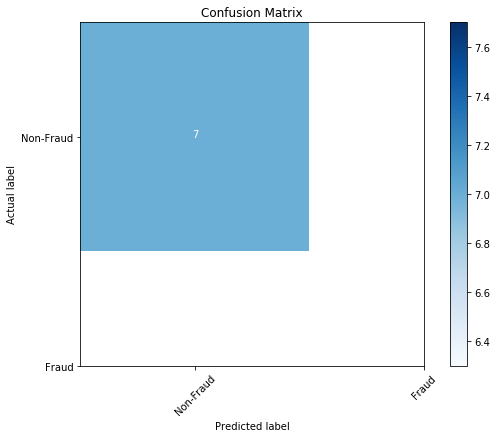

/usr/lib/python3/dist-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


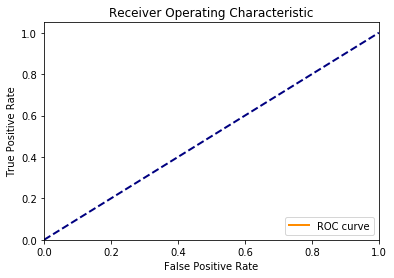

In [16]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'], rotation=45)
plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Predict on the test data
test_predictions = model.predict(test_data_scaled)

# Save the predictions to a CSV file
submission = pd.DataFrame({
    'TransactionID': pd.read_csv('test_transaction_sample.csv')['TransactionID'],
    'isFraud': test_predictions
})
submission.to_csv('submission.csv', index=False)